In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from ExternalFunctions import Chi2Regression
from iminuit import Minuit
from scipy import stats

# Import of measurements

In [2]:
# Import pendulum length measurements -- CHANGE THIS
pendulum_lengths = []
for i in range(4): # There are four of us
    # 10 measurements with mean 2000mm and std 1mm
    pendulum_lengths.append(np.random.normal(loc=2000, scale=1.00, size=10))

In [3]:
pendulum_lengths

[array([1998.75888846, 1998.76105079, 1998.75615822, 2000.30966054,
        2000.09144838, 1999.29015849, 2000.40419918, 1999.16330254,
        1999.28635008, 1999.41598637]),
 array([1999.9950916 , 2001.16692119, 2000.97319059, 2000.44123529,
        1999.26196401, 1999.17142493, 2001.66019154, 2000.75735229,
        1999.49707634, 2001.28548538]),
 array([2001.10620373, 1999.94078407, 2000.10974146, 1999.0446046 ,
        1999.42528413, 1998.6491499 , 1999.98441661, 1999.60081251,
        1999.8368567 , 1997.50378106]),
 array([1999.43435834, 1999.64775922, 2000.48673378, 2000.65926435,
        2000.81948383, 2000.21036517, 1999.83132423, 2000.52337199,
        1998.56140782, 2000.54049877])]

In [4]:
# Import pendulum period measurements -- CHANGE THIS
# Assuming 25 continuous measurements of the time when the pendulum passes a fixed point in the oscillation trajectory
pendulum_periods = []
for _ in range(4):
    pendulum_periods.append(np.cumsum(np.random.normal(loc=3, scale=0.5, size=25)))

In [5]:
pendulum_periods

[array([ 2.81155844,  5.70860979,  8.9424198 , 11.33557569, 14.71513464,
        18.15156712, 21.26134893, 24.24030198, 27.27058005, 29.89391679,
        32.48158243, 34.85771313, 38.8060867 , 41.57398216, 45.11593687,
        48.41585193, 51.31232879, 54.08850022, 57.36778397, 60.47223361,
        63.46497991, 66.15158964, 68.62099175, 71.12488787, 73.7975583 ]),
 array([ 2.80728321,  5.34297307,  8.2274142 , 10.13625556, 13.08656113,
        16.01056963, 19.1409471 , 22.11382859, 24.34427553, 27.18431635,
        29.87379163, 33.70178569, 36.73765414, 40.04890441, 42.82096543,
        44.86812595, 47.53988083, 49.77423515, 52.4964181 , 55.09057469,
        58.28876126, 61.6289614 , 64.76989098, 67.65517804, 70.37084947]),
 array([ 3.5817633 ,  6.98992491, 10.31927749, 12.90304623, 15.71940898,
        18.45678899, 22.24783437, 24.35133264, 26.68769524, 30.3320533 ,
        33.09127069, 35.85836241, 38.75615562, 41.51908755, 44.58600114,
        47.61520812, 50.12513366, 51.74836525, 

# Visualization

<Axes: ylabel='Count'>

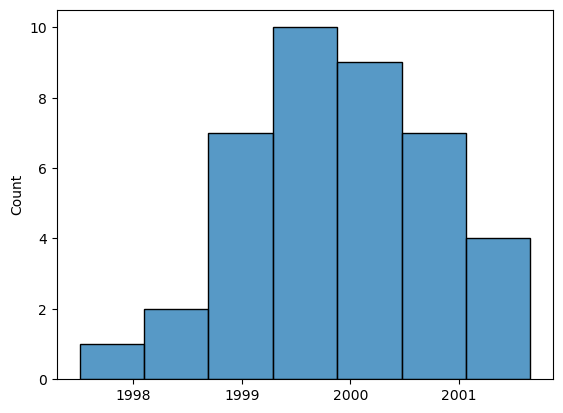

In [6]:
sns.histplot(x=np.concatenate(pendulum_lengths))

<Axes: ylabel='time'>

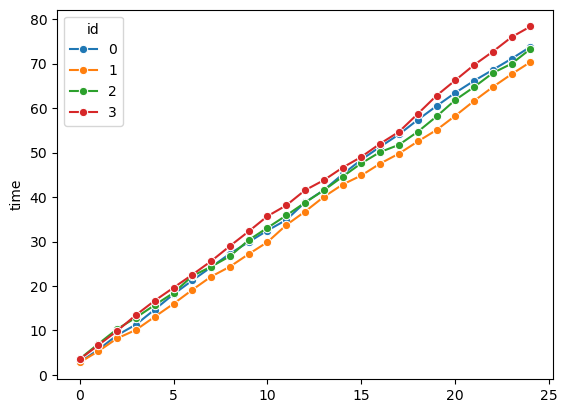

In [7]:
max_laps = max([len(lengths) for lengths in pendulum_periods])
ids = np.concatenate([np.repeat(i, len(mes)) for i, mes in enumerate(pendulum_periods)])
laps = np.concatenate([range(len(mes)) for mes in pendulum_periods])
periods_df = pd.DataFrame({'id': ids, 'laps': laps ,'time': np.concatenate(pendulum_periods)})
sns.lineplot(periods_df, x=laps, y='time', hue='id', markers=True, marker='o', palette=sns.color_palette()[:len(pendulum_periods)])

# Uncertainty

### Pendulum length

In [8]:
length_means = [np.mean(lengths) for lengths in pendulum_lengths]

# RMS: sqrt ( ( 1 / N - 1 ) * sum_{i} (xi - mu)^2 )
length_rms = [np.sqrt(sum(np.power((lengths - np.mean(lengths)), 2)) / (len(lengths) - 1)) for lengths in pendulum_lengths]

print(f'Pendulum length means: {length_means}')
print(f'Pendulum length RMS: {length_rms}')

Pendulum length means: [1999.4237203043006, 2000.4209933151833, 1999.5201634782957, 2000.071456747811]
Pendulum length RMS: [0.6345118563866448, 0.8942794126743137, 0.9673559866270596, 0.7027221694688918]


### Pendulum length uncertainty cross-check

In [9]:
mean_length_means = np.mean(length_means)

In [10]:
# Compute the error by CLT
error_length = np.sqrt(sum(np.power(length_rms, 2)) / np.power(len(pendulum_lengths), 2))
print(f'Pendulum length by CLT: {mean_length_means:.4f} \u00B1 {error_length:.4f}')

Pendulum length by CLT: 1999.8591 ± 0.4056


In [11]:
# Compute the error by RMS
rms_length_means = np.sqrt(sum([np.power(mean - mean_length_means, 2) for mean in length_means]))
print(f'Pendulum length by RMS: {mean_length_means:.4f} \u00B1 {rms_length_means:.4f}')

Pendulum length by RMS: 1999.8591 ± 0.8156


## OTHER CROSS-CHECKS FOR THE DIFFERENT WAYS OF MEASURING THE LENGTH!

### Pendulum period

In [12]:
# Fit line with minuit to get the slope as a measure of the period along with the uncertainty
def fit_function(x, T, t0):
    return T * x + t0

chi2_objects = [Chi2Regression(fit_function, range(len(time)), time) for time in pendulum_periods]
minuit_objects = [Minuit(chi2, T=3, t0=0) for chi2 in chi2_objects]
periods = []
t0s = []
for minuit in minuit_objects:
    minuit.migrad(); # fit the lines
    periods.append(minuit.values['T'])
    t0s.append(minuit.values['t0'])

print(f"Fitted lines' slopes (pendulum periods): {periods}")
print(f't0: {t0s}')

Fitted lines' slopes (pendulum periods): [2.9979859305333356, 2.828264601285989, 2.865306953055021, 3.096719017641491]
t0: [2.9034896556126273, 2.2232408472119007, 4.236779149304406, 3.856376998299532]


/Users/ervindervishaj/Documents/projects/AppStatProject/ExternalFunctions.py:113: VisibleDeprecationWarning: make_func_code is deprecated: Use of ``func_code`` attribute to declare parameters is deprecated. Use ``_parameters`` instead, which is a dict of parameter names to limits.
  self.func_code = make_func_code(describe(self.f)[1:])


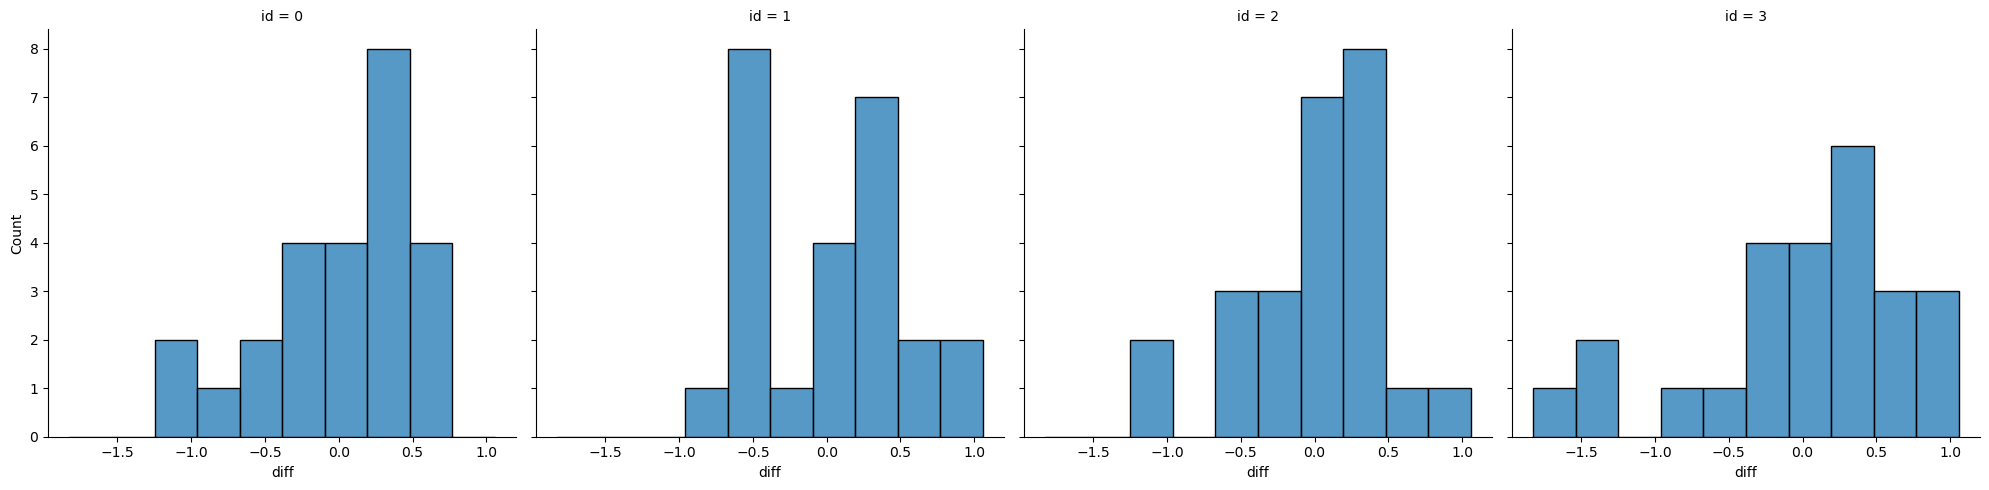

In [13]:
# Compute fit line lap times
computed_times = [np.arange(max_laps, dtype=np.int32) * T + t0s[i] for i, T in enumerate(periods)]

# Compute the differences squared
point_line_diff = [time - computed_times[i] for i, time in enumerate(pendulum_periods)]

# Show histograms of the differences
sns.displot(pd.DataFrame({'id': np.repeat([0, 1, 2, 3], max_laps), 'diff': np.concatenate(point_line_diff)}), x='diff', col='id')

In [14]:
# Compute sigmas for the lap measurements
lap_sigmas = [np.std(diff) for diff in point_line_diff]

# Refit LS and get Chi2 values along with perio
nfit_var = 2
ndof_fit = [len(time) for time in pendulum_periods]
chi2_objects = [Chi2Regression(fit_function, range(len(time)), time, lap_sigmas[i]) for i, time in enumerate(pendulum_periods)]
minuit_objects = [Minuit(chi2, T=3, t0=0) for chi2 in chi2_objects]
periods = []
period_sigmas = []
chi2s = []
chi2_probs = []
for minuit, ndof in zip(minuit_objects, ndof_fit):
    minuit.migrad(); # fit the lines
    periods.append(minuit.values['T'])
    period_sigmas.append(minuit.errors['T'])
    chi2s.append(minuit.fval)
    chi2_probs.append(stats.chi2.sf(minuit.fval, ndof))
    
print(f'New fit periods: {periods}')
print(f'Period sigmas: {period_sigmas}')
print(f'Chi2 fit values: {chi2s}')
print(f'Chi2 probabilities: {chi2_probs}')

New fit periods: [2.997985930533101, 2.8282646012855452, 2.8653069530549593, 3.0967190176415715]
Period sigmas: [0.013065144450342254, 0.014430799844489204, 0.013129448464119411, 0.0196451177689866]
Chi2 fit values: [24.999999999999815, 24.99999999999996, 25.00000000000006, 25.000000000000092]
Chi2 probabilities: [0.46237366292662363, 0.4623736629266163, 0.4623736629266103, 0.4623736629266086]


/Users/ervindervishaj/Documents/projects/AppStatProject/ExternalFunctions.py:113: VisibleDeprecationWarning: make_func_code is deprecated: Use of ``func_code`` attribute to declare parameters is deprecated. Use ``_parameters`` instead, which is a dict of parameter names to limits.
  self.func_code = make_func_code(describe(self.f)[1:])


### Pendulum period uncertainty cross-check

In [15]:
mean_period = np.mean(periods)

# Compute the error by CLT
error_period = np.sqrt(sum(np.power(period_sigmas, 2)) / np.power(len(period_sigmas), 2))
print(f'Pendulum length by CLT: {mean_period:.2f} \u00B1 {error_period:.4f}')

Pendulum length by CLT: 2.95 ± 0.0077


In [16]:
# Compute the error by RMS
rms_periods = np.sqrt(sum([np.power(mean_period - period, 2) for period in periods]))
print(f'Pendulum length by RMS: {mean_period:.2f} \u00B1 {rms_periods:.4f}')

Pendulum length by RMS: 2.95 ± 0.2140


# Error Propagation for g

In [18]:
g = mean_length_means / 1000 * np.power(2 * np.pi / mean_period, 2) # divide by 1000 due to measurement in mm
g_sigma = np.sqrt((np.power(error_length / mean_length_means / 1000, 2) + np.power(error_period / mean_period, 2)) * np.power(g, 2))

print(f'g = {g:.4f} \u00B1 {g_sigma:.4f}')

g = 9.0903 ± 0.0236
